<a href="https://colab.research.google.com/github/jgreg4/ML-ImageClassify-Tutorial/blob/main/ML_Problems_ImageClassification_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building Image Datasets and PyTorch Classification Tutorial**

##### __by J. Griego__
##### updated: 2025-04-15
<br>

##### This tutorial describes the steps for building image datasets and the methods (via transfer learning) to train models for image classification tasks. The image datasets are focused on those collected from camera trap setups capturing animals within their environments. These datasets provide an excellent learning opportunity for new users to understand steps to carefully craft training, validation, and testing datasets. The model training is done utilizing tools available from PyTorch and Scikit-learn. The steps to utilize different datasets and transfer learning models will be included in this tutorial. Metrics for determining effective model training will also be discussed. View the different Sections on the left to quickly jump to different parts of the tutorial.
<br>

##### **To quickly run as model inference mode to make predictions with a pre-trained model, skip ahead to <b>_Section 15_</b>&nbsp;**:
* Find <b>_Section 15_</b>&nbsp; by navigating to the table of contents listed on the left side of the Google Colab window
* Click on '<b>_15. Pretrained model loading from repository and inference on test images_</b>&nbsp;'
* This Section will give you the instructions to run this tutorial in inference mode
* If you instead would like to see the full model training process, proceed to the next Section

---
---
## **0. Instructions for running all code cells:**

---
* First switch to GPU runtime
  * On the top menu go to <b>_Runtime_</b> -> <b>_Change runtime type_</b> -> <b>_T4 GPU_</b> -> <b>_Save_</b>
  * GPU usage via Google Colab is limited per day/availability via shared resources
    * Try not to leave your Google Colab idle for too long while on GPU runtime- you will use up your daily quota quickly
    * See <b>_Section 3_</b> for more details
* On your keyboard press <b>_Ctrl + F9_</b>
  * Or on the top menu go to <b>_Runtime_</b> and click on <b>_Run all_</b>
* Click <b>_connect to Google Drive_</b> when prompted to do so
* Click on your google username to choose your account
  * You should be signed into your google account to use Google Colab so your username should already be available to click on
* Click <b>_Continue_</b> for terms of service
* Click <b>_Continue_</b> for google drive access

---
##### Information on expected processing time:

##### The total time to process the entire Google Colab notebook (all code cells) with GPU processing:
* 5 - 7 minutes
* Dataset size for this example ~22 MB
<br>

##### Worst case scenario with CPU processing (this is dependent on the size of your training, validation, test dataset):
* Up to 1.5 - 3 hours
* Dataset size for this example ~22 MB

<br>

---
##### Code details:
* All the required library imports are loaded in this first code cell to ensure the environment dependencies are met
* 2 different models for transfer learning can be specified by either setting 'resnet18' ( [click here for resnet18 info](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18) ) or 'vgg16' ( [click here for vgg16 info](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html) ) for <b>_model_name_trial_</b>
  * These are selected within this code cell to allow to for 'Run all' mode to proceed
* 2 different pre-built datasets can be specified for use by either setting 'day' or 'night' for <b>_dataset_name_</b>
* Automated download of 2 zip files with image datasets for this tutorial from the associated GitHub repository
* Automated download of a pre-trained model for inference mode use from the associated GitHub repository
---


In [1]:
# The following is to allow access to datasets saved on google drive

from google.colab import drive
drive.mount('/content/drive')

# Libraries for standard processing
import time
import datetime
import os
import zipfile
import tempfile
import shutil
from tempfile import TemporaryDirectory

# Libraries for data manipulation
import numpy as np
from PIL import Image

# Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries PyTorch and Torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Subset, Dataset
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import datasets, transforms, models

# Libraries for Scikit-Learn metrics/model evaluation
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Helps to optimize GPU processing (when available)
cudnn.benchmark = True

# For timing all cells
startT_all = np.datetime64('now')

# Set the model name for transfer learning
model_name_trial = 'resnet18'
#model_name_trial = 'vgg16'

# Set dataset between day or night images
dataset_name = 'day'
#dataset_name = 'night'

# Download the two zip files needed for this tutorial
!wget https://github.com/jgreg4/ML-ImageClassify-Tutorial/raw/main/Dataset_images_mini_day.zip -O /content/drive/MyDrive/Dataset_images_mini_day.zip
!wget https://github.com/jgreg4/ML-ImageClassify-Tutorial/raw/main/Dataset_images_mini_night.zip -O /content/drive/MyDrive/Dataset_images_mini_night.zip

# Download a pretrained model for inference mode use
!wget https://github.com/jgreg4/ML-ImageClassify-Tutorial/raw/main/TrainedModels.zip -O /content/drive/MyDrive/TrainedModels.zip

Mounted at /content/drive
--2025-04-16 02:04:23--  https://github.com/jgreg4/ML-ImageClassify-Tutorial/raw/main/Dataset_images_mini_day.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jgreg4/ML-ImageClassify-Tutorial/main/Dataset_images_mini_day.zip [following]
--2025-04-16 02:04:23--  https://raw.githubusercontent.com/jgreg4/ML-ImageClassify-Tutorial/main/Dataset_images_mini_day.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21707526 (21M) [application/zip]
Saving to: ‘/content/drive/MyDrive/Dataset_images_mini_day.zip’

/content/drive/MyDr 100%[===================>]  20.70M  61.9MB/s 

---
---
## **1. Assemble your own dataset (option 1)**

##### This Section describes the process for building your own mini dataset (1250 images) from scratch. The image dataset here is composed of camera trap images of animals (deer, puma, elk, coyote, and bear). The dataset has both day and night images (625 day and 625 night).
<br>

##### To assemble an image dataset, take the following steps:
---
  * Build dataset from camera trap repositories
    * Dataset description
      * Collect full resolution images that clearly show your class (not to be confused as python class) of interest
        * This could be different flower types, animal types, or other features of interest
    * When sourcing images:
      * Find images that are public domain
    * This tutorial: 5 animal classes of interest (deer, puma, elk, coyote, bear)
      * Keep separate datasets/folders of color images vs gray type images
        * Day (color) vs Night (gray)
        * If you keep a balanced number of color vs gray images you can mix the day and night images (this could lead to poor validation losses and accuracies)
      * Doing this led to 5 different class folders '0' - '4'
    * Number of images:
      * Collected ~ 125 unique images for each class
        * Ideally there would be more numbers per class, but the low number is due to time limitations and the repo only containing enough images for 125 color puma and 125 gray puma image types
        * Potential for growth/future work could be to add more images from new sources
          * This could be done by simply adding more images to each folder for training, validation, and testing
      * 100 training images per class (80%)
      * 12 validation images per class (10%)
      * 13 testing images per class (10%)
      * This is a tiny dataset (but works for tutorial purposes), for comparison, ImageNet contains ~1000 images per class
  * Database folder structure:
    * Dataset_/train/
      * class_0
        * 0001.jpg
        * ...
        * 0100.jpg
      * ...
      * class_4
        * 0001.jpg
        * ...
        * 0100.jpg
    * Dataset_/val/
      * class_0
        * 0001.jpg
        * ...
        * 0012.jpg
      * ...
      * class_4
        * 0001.jpg
        * ...
        * 0012.jpg
    * Dataset_/test/
      * class_0
        * 0001.jpg
        * ...
        * 0013.jpg
      * ...
      * class_4
        * 0001.jpg
        * ...
        * 0013.jpg
  * Class naming description (i.e. output labels this could be either color or gray depending on which dataset you want to try)
    * class_0 : deer
    * class_1 : puma
    * class_2 : elk
    * class_3 : coyote
    * class_4 : bear
---
Example of image repositories/sources:
* Image Source 1: eMammal camera trap research project
  * Link: [eMammal](https://emammal.si.edu/)
  * Search an animal class name ('deer') and save images as *.jpg or similar
* Image Source 2: US Fish and Wildlife Service
  * Link: [FWS](https://www.fws.gov/search/images?$keywords=%22deer%22)
  * The above searches for images of 'deer'
* Image Source 3: US National Park Service
  * Link: [NPS](https://www.nps.gov/media/multimedia-search.htm#sort=score+desc&q=deer)
* This tutorial's zipped datasets are located here for ease and further inspection:
  * Link:  [jgreg4 GitHub](https://github.com/jgreg4/ML-ImageClassify-Tutorial)
  * 'Dataset_images_mini_day.zip' (~21 MB)
  * 'Dataset_images_mini_night.zip' (~12 MB)
    * Google Drive has 15 GB capacity for free-tier
    * GitHub has 500 MB capacity for  free-tier
---
Other image selection notes/tips:
  * Ideally, do not mix gray and color type images in the same folder unless you have an equal balance between the two types
  * Do not use images collected from video frames (there is not enough variation to adequately train the model between sequential frames)
    * A separate model that learns from only video frames can be completed by using ~10 different videos as the training, validation, and test data
    * Make sure that all the chosen video frames have some uniqueness where animals or feature of interest have unique backgrounds, etc
  * Keep a separate folder for each training, validation, and test image set
  * If you decide to perform image transformations, treat all transformed images as the same class that they originated from (do not mix training and validation and/or test)
    * You do not want transformed images in both the training set and testing set (keeping separate folders will prevent this)
    * If you do this you will bias your model/overtrain on already 'seen' data

---

---
---
## **2. Borrow or download a dataset (options 2 - 4)**


##### To borrow/download a dataset, take the following steps:

* This method is not recommended for this tutorial since the datasets (Caltech and ImageNet) are too large for a standard Google Drive upload
  * Google Drive has 15 GB capacity for free-tier
* These options are just included for awareness
---       
  * Download from Caltech Camera Traps (option 2)
    * Full resolution images
    * Dataset size: ~105 GB
      * This is too large for a tutorial
    * [Caltech Camera Traps](https://lila.science/datasets/caltech-camera-traps)
---
  * Download from ImageNet (option 3)
    * Images scaled to 64 x 64
    * Dataset size: ~12.5 GB (unscaled dataset is ~1.08 TB)
      * This is too large for a tutorial
    * [ImageNet 64x64](https://image-net.org/download.php)
---
  * Load in CIFAR-10 from Torchvision (option 4)
    * Images scaled to 32 x 32
    * Dataset size: ~170 MB
      * This unfortunately did not have the classes/animal types of interest
    * [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
    * Code cell below shows how to load in and display some images
    * Closest classes to what this tutorial seeks
      * deer
      * horse
      * dog
      * cat
    * Resolution on these images is poor, custom image dataset resolutions much better
---
##### Code details:
* The below code cell shows the process to load in CIFAR-10 dataset
* The code cells are split into three separate cells to first load images, second to sort the images into the desired classes deer, horse, dog, and cat, and finally to display some images

---

In [2]:
# Read in CIFAR-10

# Define the classes you want
#desired_classes = ['deer', 'dog']
desired_classes = ['deer', 'horse', 'dog', 'cat']

# Load the CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter the dataset to include only the desired classes
indices = [i for i, (_, label) in enumerate(cifar10) if cifar10.classes[label] in desired_classes]
filtered_dataset = Subset(cifar10, indices)

# Count the number of images for each desired class
class_counts = {class_name: 0 for class_name in desired_classes}

for _, label in filtered_dataset:
    class_name = cifar10.classes[label]
    if class_name in class_counts:
        class_counts[class_name] += 1

# Print the counts
print("Counts of images in the filtered dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Create a DataLoader
data_loader_CF10 = DataLoader(filtered_dataset, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:06<00:00, 26.5MB/s]


Counts of images in the filtered dataset:
deer: 5000
horse: 5000
dog: 5000
cat: 5000


In [3]:
# Helper function for CIFAR-10 datset or other storage

# This cell is still a work in progress, future iterations hosted on the GitHub
#   repository will hopefully have the CIFAR-10 dataset routed for transfer
#   learning training

def _temp_image_folder():
  image_folder = './Dataset_images_online'
  if not os.path.exists(image_folder):
    os.makedirs(image_folder)
  return image_folder

# Helper function for CIFAR-10 datset or other storage
def _clean_temp_image_folder():
  image_folder = './Dataset_images_online'
  if os.path.exists(image_folder):
    shutil.rmtree(image_folder)

# Create a temp folder to fill with images
_temp_image_folder()

# Set indexes for extracting a specific number for training, validation, testing
train_CF10_idx = list(range(0,100))
val_CF10_idx = list(range(100,112))
test_CF10_idx = list(range(112,125))

# Filter images by above indexes
train_CF10 = Subset(filtered_dataset, train_CF10_idx)
val_CF10 = Subset(filtered_dataset, val_CF10_idx)
test_CF10 = Subset(filtered_dataset, test_CF10_idx)

# Use dataloader to pull in a batch of data large enough to gather 125 images
train_loader_CF10 = DataLoader(train_CF10, batch_size=128, shuffle=False)
val_loader_CF10 = DataLoader(val_CF10, batch_size=128, shuffle=False)
test_loader_CF10 = DataLoader(test_CF10, batch_size=128, shuffle=False)

data_iter = iter(train_loader_CF10)
images, labels = next(data_iter)

print(images.shape)
print(labels.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100])


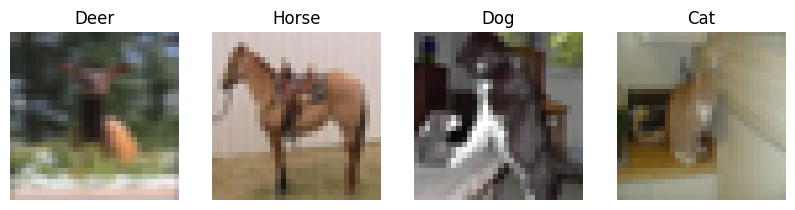

In [4]:
# Plot some CIFAR-10 images

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get the first image of deer and dog- each time you rerun this it will show a
# different deer or dog image since the dataset is shuffled above with 'TRUE'
deer_image = None
horse_image = None
dog_image = None
cat_image = None

#for inputs, labels in data_loader_CF10:
for inputs, labels in val_loader_CF10:
    # Find a deer image - label for deer is 4
    for i in range(len(labels)):
        if labels[i] == 4:
            deer_image = inputs[i]
            break
    # Find a horse image - label for dog is 7
    for i in range(len(labels)):
        if labels[i] == 7:
            horse_image = inputs[i]
            break
    # Find a dog image - label for dog is 5
    for i in range(len(labels)):
        if labels[i] == 5:
            dog_image = inputs[i]
            break
    # Find a cat image - label for cat is 3
    for i in range(len(labels)):
        if labels[i] == 3:
            cat_image = inputs[i]
            break
    if deer_image is not None and horse_image is not None and dog_image is not None and cat_image is not None:
        break

# Plot the images
plt.figure(figsize=(10, 10))

# Plot deer image
plt.subplot(1, 4, 1)
imshow(deer_image)
plt.title('Deer')

# Plot horse image
plt.subplot(1, 4, 2)
imshow(horse_image)
plt.title('Horse')

# Plot dog image
plt.subplot(1, 4, 3)
imshow(dog_image)
plt.title('Dog')

# Plot cat image
plt.subplot(1, 4, 4)
imshow(cat_image)
plt.title('Cat')

plt.show()

---
---
## **3. Change runtime type to GPU if available**


##### These steps are important to ensure efficient training times:

* The CPU training scenarios that were attempted took ~6.5x longer to train the model- GPU training is preferred.
* To switch to the GPU (this was shown above but will be re-iterated with more details about the GPU options)
  * Click __Runtime__ at the top menu bar, __Change runtime type__ to __T4 GPU__ then save the change
* GPU use is limited based on availability through Google, to subscribe for  additional GPU usage see below:
  * Google Colab Pro $9.99/mo
[Pricing](https://colab.research.google.com/signup?utm_source=resource_tab&utm_medium=link&utm_campaign=payg_learn_more)
  * Only do this if free-tier Google Colab is not sufficient for your model training needs (in most general tutorial use cases free-tier should be sufficient)
---
##### Code details:
* The below code cell checks to see if GPU usage is currently available
  * There is no GPU available if the result prints '<b>_nvidia-smi: command not found_</b> '
  * There is GPU available if it shows you GPU information with NVIDIA-SMI information, etc.

---

In [5]:
# Checks if GPU usage is available

torch.cuda.is_available()
!nvidia-smi

Wed Apr 16 02:04:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

---
---
## **4. Google Drive setup with the assembled dataset**

##### To setup Google Drive with the assembled dataset:
<br>

---
Now that the dataset has been assembled, here are some steps to ensure your code can pull in the images you are interested in processing.
* Login to your Google account (create one if you haven't already) and navigate to google drive
  * https://workspace.google.com/products/drive/
* Click '<b>_Sign in_</b> ' button
* Click on '<b>_My Drive_</b> '
* Assuming you have set up your database folder structure according to the guidlines above, you can drag and drop your zipped file into '<b>_My Drive_</b> '
* For ease find 2 zipped datasets that are ready to process here: [jgreg4 GitHub](https://github.com/jgreg4/ML-ImageClassify-Tutorial)
  * 'Dataset_images_mini_day.zip' and 'Dataset_images_mini_night.zip'
  * Upload both zip folders to your '<b>_My Drive_</b> '
    * For ease, these were both automatically downloaded in <b>_Section 0_</b>
  * You can model your own dataset after these and you would just drag and drop your zipped folder into '<b>_My Drive_</b> '
* The folder structure within the zip file looks like this:
  * Create a zipped folder called 'Dataset_images.zip'
    * Main folders:
      * train
      * val
      * test
        * Each of the above folders will contain class folders like these (modify the count of folders to fit your needs):
          * class\_0
          * class\_1
          * class\_2
          * class\_3
          * class\_4
* Also, another useful step is the load of a trained model from the GitHub repository (the file is automatically downloaded in <b>_Section 0_</b> )

---
##### Code details:
* An important variable to set is <b>_DatasetClasses_</b> :
  * Ensure you adjust this number according to your selected classes
  * Since there are deer, puma, elk, coyote, and bear, use: 5
  * If you were to instead process the CIFAR-10 example above, change it to: 4
* Another important variable to potentially adjust is <b>_new_labels_</b> :
  * This step helps in the final plotting in <b>_Section 14_</b>, <b>_Section 15_</b>, and <b>_Section 16_</b>
  * If you forget to change this you will have incorrectly labeled classes in your final plots
* Within the code there are steps to time image loading
  * This step should take ~30 seconds
* Depending on the choices for datasets in <b>_Section 0_</b>, the if statements will un-zip the correct file for processing

---


In [6]:
# Load in image datasets and trained models stored on your google drive

# Helper function to extract zip files and put them in a known location
def _unzip_files(zip_file_path, final_path):
  if not os.path.exists(final_path):
    os.makedirs(final_path)

  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(final_path)

  print(f"Zip file extracted here: {final_path}")

# For timing
startT = np.datetime64('now')

# File name selection for image datasets based on Section 0
if dataset_name == 'day':
  fileName_images = 'Dataset_images_mini_day.zip'
elif dataset_name == 'night':
  fileName_images = 'Dataset_images_mini_night.zip'
else:
  raise ValueError(f"Invalid dataset name: {dataset_name}")

# Trained model zip file
fileName_model = 'TrainedModels.zip'

# Make sure to set this accordingly- it will be used later in modeling, etc.
# depends on class count
DatasetClasses = 5 #4 or 5

# Also make sure to set specific labels that represent your dataset
# Make sure the number of labels match the 'DatasetClasses' above
new_labels = ['deer', 'puma', 'elk', 'coyote', 'bear']
#new_labels = ['deer', 'horse', 'dog', 'cat']


# Zip file path for the image datasets
images_file_path = (
    f'/content/drive/My Drive/'
    f'{fileName_images}'
    )

# Zip file path for the model file
model_file_path = (
    f'/content/drive/My Drive/'
    f'{fileName_model}'
    )

extracted_images = '/content/Dataset_images/'
extracted_model = '/content/TrainedModels/'

# Use helper function to unzip files
_unzip_files(images_file_path, extracted_images)
_unzip_files(model_file_path, extracted_model)

# For timing
endT = np.datetime64('now')
print(f"Time elapsed (seconds): {endT - startT}")

Zip file extracted here: /content/Dataset_images/
Zip file extracted here: /content/TrainedModels/
Time elapsed (seconds): 1 seconds


---
---
## **5. A quick look at a dataset sample**

##### Some extra details about the assembled dataset:

* A quick look at the assembled dataset with a program such as FIJI/ImageJ showed that there is a variety of different image sizes
  * Approximate largest: 4000 x 3000 pixels
  * Approximate smallest: 130 x 130 pixels
  * There could be larger or smaller within the entire dataset
  * This must be addressed with a preprocessing step to ensure an image size of 224 x 224 for effective uniformity between different transfer learning models etc.
  * This preprocessing was completed on each of the mini datasets
* A full resolution can still be analyzed with this tutorial, this is just mentioned because GitHub was unable to host a full resolution dataset (~ 1.1 GB), so this pre-processing was needed to reduce the datasets for the tutorial being able to download the 'mini' datasets
* The generic description of the ideal input dataset size for training (assuming color rgb) would be the following:
  * 500 x 3 x 224 x 224
  * Number of images, rgb color channels, pixel height, pixel width
  * The validation set would have 60 for the first value
  * The test set would have 65 for the first value
  * The image transformations in <b>_Section 7_</b> will turn the non-uniform sizes into a format that is ready for training, validation, and testing

<br>

---
##### Code details:

* The section immediately below is a brief code example to display images of the deer class
  * The deer class is selected by setting <b>_classNo_</b> to 0
    * This can be changed to 1 for puma, 2 for elk, 3 for coyote, and 4 for bear
  * The image number within the training set is selected by by setting <b>_imageNo_</b> to 0
    * This is the 1st image of the deer class training dataset (0001.jpg)
    * Since this particular training set has 100 images you can choose between 0 and 99
  * The path setting can also be changed to look at validation or test images
    * Change 'train' to 'val' in <b>_image_example_path_</b> for validation images (remember there are only 12 images for this set per class)
    * Change 'train' to 'test' in <b>_image_example_path_</b> for test images (remember there are only 13 images for this set per class)

---

Image size: (455, 256)


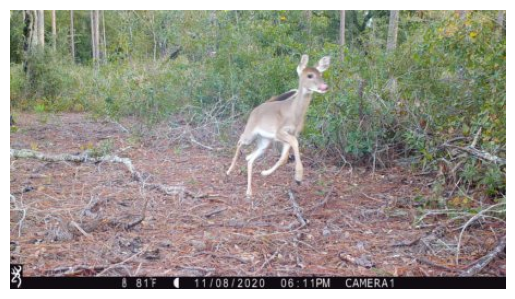

In [7]:
# Display some training images

# Class numbers in order from 0 to 4
# 0 - deer, 1 - puma, 2 - elk, 3 - coyote, 4 - bear
classNo = 0

# Image number- choose a number between 0 and 99
imageNo = 0

# Path setting
image_example_path = (
    f'/content/Dataset_images/train/'
    f'class_{str(classNo)}/'
    f'{str(imageNo+1).zfill(4)}.jpg'
)

# Opening image
img = Image.open(image_example_path)

# Display image size
print(f'Image size: {img.size}')

# Display the example image
plt.imshow(img)
plt.axis('off')
plt.show()

---
---
## **6. Read in full dataset and augment data (training, validation, and testing)**

#####  Augmenting your dataset helps if you have a limited number of images (<1000 per class) and it helps your model generalize/predict for unseen images

* Some potential augmentations could be:
  * Center cropping to remove image labeling/borders
  * Image flipping (vertical and horizontal)
  * Image rotation
  * RGB color modifications to simulate new imagery
  * Image resolution adjustments/resizing to match transfer learning model architectures
  * Normalization to match transfer learning model settings
* Important Findings (these errors lead to bad model validation loss/accuracy early on)
  * Later in this tutorial a pretrained model (resnet18) was chosen as a transfer learning model to apply
    * In choosing this model it wasn't immediately known that the images must be normalized to a certain specification (ImageNet trained models)
      * mean = [0.485, 0.456, 0.406]
      * std = [0.229, 0.224, 0.225]
    * The model would train but the model validation loss and accuracy would stall and not improve to acceptable levels- pay close attention to requirements for pretrained model usage
    * Link to more information for [resnet18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)
  
---
##### Code details:
* This code cell has been modified from this PyTorch example: [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
* Potential variables that could be useful to modify are:
  * <b>_batchSize_</b> = 32
    * This is the number of images loaded in with each model training epoch
    * 32 is good for CPU training, you can increase this to 64 or higher if you are using the GPU runtime (it will help with training times and large image sets)
    * For consistency in the tutorial, 32 was used since the training times were not too long for the mini datasets
  * <b>_rotation_angle_</b> = 30
    * This could be modified to something between 15 to 45 degrees
    * Other image tranformations such as vertical and horizontal flipping are randomly applied to augment the dataset
  * <b>_color_jitter_</b> = 0.2
    * This value will apply different color changes to your images
    * 0.2 made noticeable but not extreme changes to the default images- see <b>_Section 7_</b> for an example of the color changes applied

* More information on additional and different transforms can be found here: [PyTorch Image Transforms](https://pytorch.org/vision/main/transforms.html)

---



In [8]:
# Dataset loading and image transformation workflow

dataset_path = '/content/Dataset_images'
squareDimension = 256
finalDimension = 224 # Do not change- transfer learning models expect this image resolution
batchSize = 32
rotation_angle = 30
color_jitter_value = 0.2
normalize_mean = [0.485, 0.456, 0.406] # this is an ImageNet specification
normalize_std = [0.229, 0.224, 0.225] # this is an ImageNet specification

# Training set transforms for image conversion and augmentation
# transforms could include resize, crop, vertical flip, horizontal flip,
# rotation, image color changes
train_transform = transforms.Compose([
    transforms.Resize((squareDimension, squareDimension)),
    transforms.CenterCrop(finalDimension),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(rotation_angle),
    transforms.ColorJitter(brightness=color_jitter_value,
                           contrast=color_jitter_value,
                           saturation=color_jitter_value,
                           hue=color_jitter_value
                           ),
    transforms.ToTensor(),
    transforms.Normalize(normalize_mean, normalize_std)
])

# Validation and Test set transforms for image conversion and augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((squareDimension, squareDimension)),
    transforms.CenterCrop(finalDimension),
    transforms.ToTensor(),
    transforms.Normalize(normalize_mean, normalize_std)
])

# Set training, validation, and test set path and associated transforms
train_data = datasets.ImageFolder(
    root=f'{dataset_path}/train',
    transform=train_transform
)
val_data = datasets.ImageFolder(
    root=f'{dataset_path}/val',
    transform=val_test_transform
)
test_data = datasets.ImageFolder(
    root=f'{dataset_path}/test',
    transform=val_test_transform
)

# Use Dataloader with to load data
train_loader_example = DataLoader(train_data, batch_size=batchSize, shuffle=False)

train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batchSize, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batchSize, shuffle=True)

# Extract data sizes
train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)

# Print the sizes
print(f"Training size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

# Print the labels
class_labels = train_data.classes
print("Default Labels:", class_labels)
print("New Labels for plotting:", new_labels)

Training size: 500
Validation size: 60
Test size: 65
Default Labels: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4']
New Labels for plotting: ['deer', 'puma', 'elk', 'coyote', 'bear']


---
---
## **7. Image transformation Vs raw image example**

#####  This section allows you to see how the image transformations change your raw input images. The example below rotates the image by 30 degrees and also applies a color change to the raw input example. Use this section to see what values you would like to apply to your <b>_Section 6_</b> variables.
---
##### Code details:
* This code has been modified from this PyTorch example: [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
* The primary modification that you can apply for this code cell is changing <b>_image_exampleNo_</b>
  * The value can be a value between 0 and 31 since the batch size is set in <b>_Section 6_</b> to 32
  * If you change the batch size to 64 in <b>_Section 6_</b> you can then access 0 to 63, etc
---


Transformed image size (num channels, pixel height, pixel width):
torch.Size([3, 224, 224])


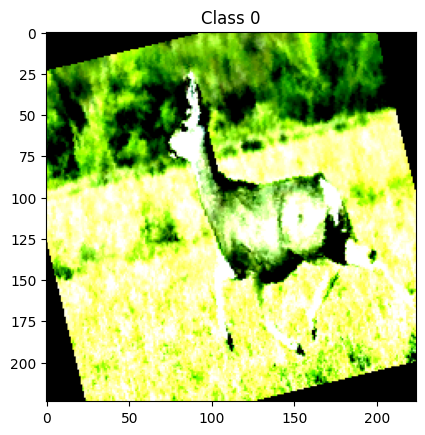


Raw image size (num channels, pixel height, pixel width):
(3, 256, 512)


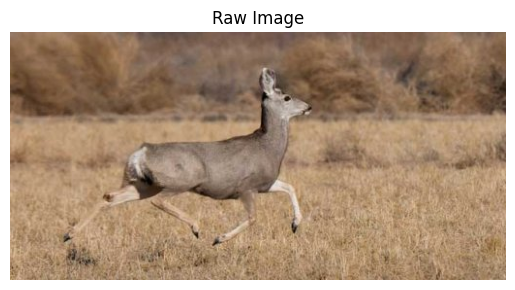

In [9]:
# Pick a number between 0 and 31- since batch size is 32
# This is to display different example images
image_exampleNo = 6

# Helper function for image plotting
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
dataiter = iter(train_loader_example)
images, labels = next(dataiter)

# Get a single image (first image from the batch)
image = images[image_exampleNo]
label = labels[image_exampleNo]

# Get and print the transformed image size
print(
    f'\nTransformed image size (num channels, pixel height, pixel width):\n'
    f'{image.shape}'
    )

# Plot the image
imshow(image, title=f"Class {label.item()}")

# Set path to image database within google colab
image_example_path = (
    f'/content/Dataset_images/train/class_0/'
    f'{str(image_exampleNo+1).zfill(4)}.jpg'
)
img = Image.open(image_example_path)

# Get and print the raw image size
img_array = np.array(img)
print(
    f'\nRaw image size (num channels, pixel height, pixel width):\n'
    f'{img_array.shape[2],img_array.shape[0],img_array.shape[1]}'
    )

# Show the example image
plt.imshow(img)
plt.axis('off')
plt.title('Raw Image')
plt.show()

---
---
## **8. Model training class**

##### This section sets up the model training process, below are some details:
* This method has been modified from this PyTorch example: [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
* The above tutorial uses a single function for a complex process
  * With all of the steps in one function it is difficult to follow the train and validation steps
  * Also the single function does not have an early-stopping sequence
* Using a python class with separate helper functions helps with code-reusability and to aid in understanding the complex process
* Separate helper functions for training, validation, early-stopping, and model tracking accomplish the same outcome as the linked tutorial with added features
* The added early-stopping helper function ensures that your model only trains for the required amount of time
  * Saves time by finding a local minima for a low validation loss and stops if additional epochs are not improving the model
  * Also tracks training loss/accuracy and validation loss/accuracy for plotting in <b>_Section 12_</b>
---
* Important findings to share about errors in my process:
  * Failing to identify these errors early on led to an underestimation of model training loss/accuracy:
    * Training seemed to perform better than it actually was
    * This was because the training loss was being calculated incorrectly
 * The cause:
   * Incorrect indentation for a variable—pay close attention to indentation when writing Python code
   * An error in the <b>_running_loss_</b> parameter within my <b>__train_epoch__</b> helper function resulted in training losses and accuracies that appeared too good during the early epochs
  * The solution:
    * The issue was resolved by ensuring the loop for loss calculation was correctly indented within the correct code block
  
---
##### Code details:
* Some potential modifications if desired:
  * You can increase the <b>_num_epochs_</b> default to something like 100 or higher
    * This is the maximum number of training epochs that can occur, but early stopping metrics will hopefully stop well before this (if training is going well)
    * Also, when you begin training in <b>_Section 11_</b> these values will be reset as needed
  * You can increase the <b>_epoch_thresh_</b> default to something like 15 or higher
    * This value helps with early stopping
    * If the validation loss does not decrease within this number of epochs, then training ceases
    * This is essentially the process to find a good local minima for validation loss
  * Other inputs for the <b>_Model_Train_</b> will be set in <b>_Section 11_</b>
---


In [10]:
# Model Training class with helper functions

class Model_Train:
    def __init__(self, model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25, epoch_thresh = 3, device='cpu'):
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.model = model.to(device)

        # Use default conditions if no configuration dictionary is given
        self.config = {
            'device' : device,
            'num_epochs': num_epochs,
            'epoch_thresh': epoch_thresh,
            'train_normal': True
            }

        # Initialize variables
        self.best_model_params_path = None
        self.best_acc = 0.0
        self.best_loss = float('inf')
        self.epoch_val_counter = 0
        self.best_epoch = -1

        # Dictionaries to log loss and accuracy
        self.metrics = {
            'train': {'loss': [], 'acc': []},
            'val': {'loss': [], 'acc': []}
            }

        # Dataset sizes
        self.dataset_sizes = {
            'train': len(train_loader.dataset),
            'val': len(val_loader.dataset)
            }

    # Helper function save model at each epoch
    def _checkpoint_save(self):
        model_save_dir = './model_checkpoints/'
        if not os.path.exists(model_save_dir):
            os.makedirs(model_save_dir)
        self.best_model_params_path = os.path.join(model_save_dir, 'best_model_params.pt')
        torch.save(self.model.state_dict(), self.best_model_params_path)

    # Helper function training at each epoch
    def _train_epoch(self):
        self.model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in self.train_loader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            self.optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = self.criterion(outputs, labels)

                loss.backward()
                self.optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / self.dataset_sizes['train']
        epoch_acc = running_corrects.double() / self.dataset_sizes['train']

        return epoch_loss, epoch_acc

    # Helper function validation at each epoch
    def _val_epoch(self):
        self.model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / self.dataset_sizes['val']
        epoch_acc = running_corrects.double() / self.dataset_sizes['val']

        return epoch_loss, epoch_acc

    # Helper function for early stopping
    def _early_stop_check(self, epoch_loss, epoch_acc, epoch):
        if epoch_loss < self.best_loss:
            self.best_loss = epoch_loss
            self.best_acc = epoch_acc
            self.best_epoch = epoch
            torch.save(self.model.state_dict(), self.best_model_params_path)
            self.epoch_val_counter = 0
        else:
            self.epoch_val_counter += 1

        if self.epoch_val_counter >= self.config['epoch_thresh']:
            print(f'Early stopping at epoch {epoch} due to no improvement in validation loss.')
            self.config['train_normal'] = False

    # Helper function to finalize and extract important parameters
    def _finalize_training(self, start_time):
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {self.best_acc:4f} at epoch {self.best_epoch + 1}')

        self.model.load_state_dict(torch.load(self.best_model_params_path, weights_only=True))
        self.model.train_losses = self.metrics['train']['loss']
        self.model.val_losses = self.metrics['val']['loss']
        self.model.train_accuracies = self.metrics['train']['acc']
        self.model.val_accuracies = self.metrics['val']['acc']

    # Training function that utilizes the above helper functions
    def _training(self):
        self._checkpoint_save()

        start_time = time.time()
        for epoch in range(self.config['num_epochs']):
            print(f'Epoch {epoch}/{self.config["num_epochs"] - 1}')
            print('-' * 10)

            # Training phase
            train_loss, train_acc = self._train_epoch()
            self.metrics['train']['loss'].append(train_loss)
            self.metrics['train']['acc'].append(train_acc)
            print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

            # Validation phase
            val_loss, val_acc = self._val_epoch()
            self.metrics['val']['loss'].append(val_loss)
            self.metrics['val']['acc'].append(val_acc)
            print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

            # Step scheduler after each epoch
            self.scheduler.step()

            # Check for early stop conditions
            self._early_stop_check(val_loss, val_acc, epoch)
            if not self.config['train_normal']:
                break

        # Finalize model and collect important parameters
        self._finalize_training(start_time)

        # Clean up
        model_checkpoints_dir = './model_checkpoints/'
        if os.path.exists(model_checkpoints_dir):
            shutil.rmtree(model_checkpoints_dir)

        return self.model

---
---
## **9. Function for plotting a trained model**

##### This section sets up the plotting process for a trained model to make predictions on testing images, below are some details:
* This plotting method has been minimally modified from this PyTorch example: [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
* A necessary step was to make sure any of the test images have the mean and standard deviation added back so that a raw image will be viewed rather than the transformed/augmented image
* The predictions will still be on the transformed image so that the model can appropriately determine the correct class
---

In [11]:
# Plotting function to make predictions on test images

def visualize_model(model, dataloader, class_names, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))

    def imshow(inp, title=None):
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        if title:
            plt.title(title)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                predicted_label = class_names[preds[j]]
                true_label = class_names[labels[j]]
                line1 =f'Predicted Class: {predicted_label}'
                line2 =f'\n True Class: {true_label}'
                ax.set_title(line1 + line2)
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

---
---
## **10. PyTorch model assemble**

##### This section sets up the transfer learning model based on selections in <b>_Section 0_</b>&nbsp; and <b>_Section 4_</b> , below are some details:
* This transfer learning model setup has been modified from this PyTorch example: [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
* Changes from linked tutorial:
  * Addition of 'vgg16' transfer learning model option
  * Addition of 'Adam' optimizer option

---
##### Code details:
* A variable that you will likely modify depending on how your training is going is the <b>_learning_rate_</b>
  * A default starting value will be 0.001
    * lr = 0.00007 worked well for the Adam optimizer
  * You will modify this value based on how your learning curves appear in <b>_Section 12_</b>
  * Your goal is to have a smooth descending curve for both your training and validation loss
  * If the curves descend too quickly your <b>_learning_rate_</b> value is too large
    * Skipping over important features within your training images
  * If the curves never reach a relatively low value for either training or validation loss your <b>_learning_rate_</b> is too small
    * Increase the value to allow the model to learn important distinguishing features in your images
  * It is also important to pay attention to both the training and validation accuracy curves
    * You want these to be as close to 1 as possible
    * Some instances may not produce high accuracies if you have smaller datasets or if the image quality is not good enough to extract distinguishing features
* Another variable that you can modify is the <b>_optimizer_trial_</b>
  * Choose either 'Adam' or 'SGD'
  * Here's more information and additional optimizers to consider [PyTorch Optimizers](https://pytorch.org/docs/stable/optim.html)
---

In [12]:
# Transfer Learning Model Setup
learning_rate = 0.00007
optimizer_trial = 'Adam' # or 'SGD'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setting model parameters based on Section 4 number of filters
if model_name_trial == 'resnet18':
  # Pull in a transfer learning model resnet18
  model_ft = models.resnet18(weights='IMAGENET1K_V1')
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Linear(num_ftrs, DatasetClasses)

elif model_name_trial == 'vgg16':
  # Pull in a transfer learning model vgg16
  model_ft = models.vgg16(weights='IMAGENET1K_V1')
  num_ftrs = model_ft.classifier[6].in_features
  model_ft.classifier[6] = nn.Linear(num_ftrs, DatasetClasses)

else:
  raise ValueError(f"Invalid model name: {model_name_trial}")

# Move model to correct device for processing either GPU or CPU
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Select Model Optimizer SGD or Adam
if optimizer_trial == 'SGD':
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)
elif optimizer_trial == 'Adam':
  optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate)
else:
  raise ValueError(f"Invalid optimizer name: {optimizer_trial}")

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


---
---
## **11. Train the model with specific criteria**

##### Model training time info:
* Depending on if you are training on CPU vs GPU, this can take significant time:
  * CPU training could be ~3 hours, so be patient
  * Train with GPU when possible- most training times were under 10 minutes when utilizing Google Colab's GPU runtime

---
##### Code details:
* There are a couple of variables that can be reset in this code cell:
  * <b>_num_epochs_</b> has a default value of 25 that was defined in <b>_Section 8_</b>, the below sets the max number of epochs to 100
  * <b>_epoch_thresh_</b> has a default value of 3 that was defined in <b>_Section 8_</b>, the below sets the early stopping threshold to 15 epochs
    * stops training if no improvements occur within 15 epochs or a validation loss minima
---
<br>

##### A few examples of completed training sessions are listed in the table below. Attempt A vs B shows the effect of training on the GPU vs CPU (the time is much greater for the CPU training). Also, notice that the validation loss for these 2 examples were high compared to examples C-E. This was due to the error of forgetting to normalize the images as prescribed by the ImageNet protocol (see <b>_Section 6_</b>) before training on the images. The remaining examples C-E all used identical learning rate = 0.00007 and Adam optimizer for ease in comparison. Note that the learning rate should be adjusted to acheive as low of a validation loss as possible. In this case, it was kept constant for comparison purposes. The best outcome for the model training occured with the 'rgb'/day image set and with the 'resnet18' transfer learning model. This resulted in a validation loss of 0.2439 and validation accuracy of 93.33%.
<br>

##### <center> Trained Model Examples</center>

<center>

| Attempt #  | GPU or CPU  | Model Type | Image Type | Training Time  | Optimizer | Val Loss/Acc |
|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
| A | GPU | resnet18 | rgb & gray | 23m 57s | SGD | 1.8936 / 0.2750 |
| B | CPU | resnet18 | rgb & gray | 155m 18s | SGD | 1.6193 / 0.4167 |
| C | GPU | resnet18 | rgb | 5m 15s | Adam | 0.2288 / 0.9333 |
| D | GPU | vgg16 | rgb | 11m 2s | Adam | 0.2506 / 0.9000 |
| E | GPU | resnet18 | gray | 5m 15s | Adam | 0.4261 / 0.8667 |

</center>

---

In [13]:
# If says 'cuda' means it is training on GPU, otherwise with CPU-this will be much slower
# From a comparison CPU took ~6.5x longer than GPU

print(f"Training on device: {device}")

model_trainer = Model_Train(
    model_ft,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    train_loader,
    val_loader,
    num_epochs = 100,
    epoch_thresh = 15,
    device=device
    )

trained_model = model_trainer._training()

Training on device: cuda
Epoch 0/99
----------
Train Loss: 1.4333 Acc: 0.3640
Val Loss: 0.9731 Acc: 0.6500
Epoch 1/99
----------
Train Loss: 1.0471 Acc: 0.6000
Val Loss: 0.6974 Acc: 0.7833
Epoch 2/99
----------
Train Loss: 0.8686 Acc: 0.6960
Val Loss: 0.5131 Acc: 0.8500
Epoch 3/99
----------
Train Loss: 0.6927 Acc: 0.7760
Val Loss: 0.4913 Acc: 0.8500
Epoch 4/99
----------
Train Loss: 0.5919 Acc: 0.7900
Val Loss: 0.3869 Acc: 0.8667
Epoch 5/99
----------
Train Loss: 0.5268 Acc: 0.8240
Val Loss: 0.3835 Acc: 0.8500
Epoch 6/99
----------
Train Loss: 0.4427 Acc: 0.8540
Val Loss: 0.3485 Acc: 0.9000
Epoch 7/99
----------
Train Loss: 0.3979 Acc: 0.8660
Val Loss: 0.3068 Acc: 0.8833
Epoch 8/99
----------
Train Loss: 0.3813 Acc: 0.8820
Val Loss: 0.2772 Acc: 0.9000
Epoch 9/99
----------
Train Loss: 0.3160 Acc: 0.9200
Val Loss: 0.2711 Acc: 0.9167
Epoch 10/99
----------
Train Loss: 0.2667 Acc: 0.9240
Val Loss: 0.2582 Acc: 0.9167
Epoch 11/99
----------
Train Loss: 0.2398 Acc: 0.9300
Val Loss: 0.2555 A

---
---
## **12. Trained model evaluation with learning curves**
##### Since training/validation loss and training/validation accuracy were logged  within the model training class (<b>_Section 8_</b>&nbsp;), the training progress can easily be visualized.
* Plotting the loss and accuracy values as a function of epoch can show you if the training is proceeding correctly
* The goal is to have training and validation loss (left-hand vertical axes) decrease in a smooth descent towards a value close to zero
  * You do not want rough and abrupt changes in the loss values
  * If this is occuring you need to make a change in your learning rate to produce a smoother descent
  * If your loss values are remaining high, you may want to increase your learning rate since your model may be unable to learn enough from your data to produce small loss values

<br>

##### Another region of the plot to pay close attention to is the training and validation accuracy (right-hand vertical axes)
* You want this to increase as more epochs are completed
* Aim for validation accuracy values to be as high as possible (close to 1)
  * Some classification problems may be unable to get high values for accuracy, some potential problems could be:
    * Not enough images in your training and validation set
    * Images that are not showing your features of interest clearly
    * Potentially try a different model optimizer to see if it helps the accuracy and loss values

---

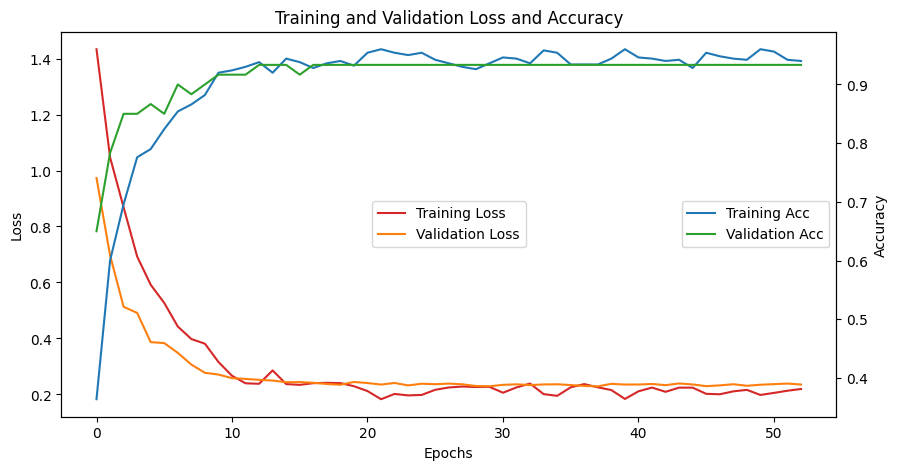

In [14]:
# Learning curve plots (train and val Loss / train and val Accuracy)

train_loss = trained_model.train_losses
val_loss = trained_model.val_losses

train_acc = trained_model.train_accuracies
val_acc = trained_model.val_accuracies

# Move tensors to CPU and convert to NumPy arrays if needed
train_loss = [loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_loss]
val_loss = [loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_loss]
train_acc = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_acc]
val_acc = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_acc]

def plot_loss_acc(train_loss, val_loss, train_acc, val_acc):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot the training and validation loss on the primary y-axis
    ax1.plot(train_loss, label='Training Loss', color='tab:red')
    ax1.plot(val_loss, label='Validation Loss', color='tab:orange')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    # Create a secondary y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.plot(train_acc, label='Training Acc', color='tab:blue')
    ax2.plot(val_acc, label='Validation Acc', color='tab:green')
    ax2.set_ylabel('Accuracy')


    # Title and legends
    ax1.set_title('Training and Validation Loss and Accuracy')
    ax1.legend(loc='center')
    ax2.legend(loc='right')

    plt.show()

plot_loss_acc(train_loss, val_loss, train_acc, val_acc)

---
---
## **13. Save your trained model**
##### This section simply saves your model at the point that your validation loss is the lowest.
* It will automatically append the model file with a time stamp
  * There should be no issue with overwritting a good model since the name is tied to a time stamp
  * Saved model file will have *.pth file extension
* Some things to consider about this automated model saving process:
  * This process will save a model to your Google 'My Drive' every time you run this code cell
    * Be sure to clear out any models you don't intend to keep so that you don't run out of space on your Google 'My Drive'
    * Remember Google Drive has 15 GB capacity for free-tier
    * The models saved in this tutorial ranged from 40 - 500 MB

---

In [15]:
# Save Model - un comment below if you would like to save the resulting model

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_path = f'/content/drive/MyDrive/model_ft_{current_time}.pth'
torch.save(trained_model.state_dict(), save_path)
print(f'Model saved to {save_path}')

Model saved to /content/drive/MyDrive/model_ft_2025-04-16_02-10-09.pth


---
---
## **14. Trained model inference on test images**
##### This code cell will perform model inference on test images to make a prediction about which class an unseen image belongs to. The <b>_visualize_model_</b>&nbsp; function will display the predicted class as the top title and the true class/label as the bottom title for each image. Notice that there may be some instances where the model misidentifies certain classes. Such as confusing deer with elk or coyote with puma. This could be due to the similarities between the animals. The model does a good job picking out the bear within test images.
* You can run the code cell multiple times by pressing the play/run button that appears when you hover over the left-side of the code cell
  * This will pull in a new set of test images for predictions
---

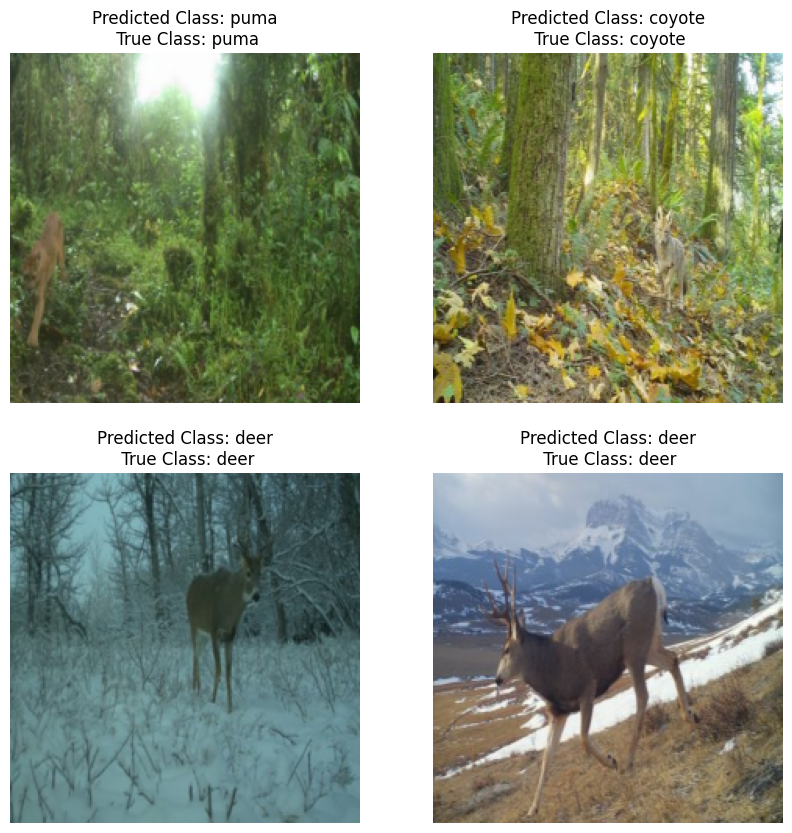

In [16]:
# Try out some test images (original 'class_names=test_data.classes')

visualize_model(trained_model, dataloader={'test': test_loader}, class_names=new_labels)

# Class numbers in order from 0 to 4
# 0 - deer, 1 - puma, 2 - elk, 3 - coyote, 4 - bear

---
---
## **15. Pretrained model loading from repository and inference on test images**



##### If you jump to this Section and assuming you have a trained model to load/visualize- make sure you take these steps:
* The automatically loaded model from the GitHub repository was trained with 'resnet18'- make sure to apply the 'resnet18' setting in <b>_Section 0_</b>&nbsp; for <b>_model_name_trial_</b>&nbsp;
  * If you do not apply this change, you will get an error for the code cell
* Next, run the code in the listed Sections before you attempt this code cell:
  * Sections (use the Table of contents to quickly navigate to these sections one at a time):
    * 0
    * 4
    * 6
    * 9
    * 10
    * 15
  * To run the code only in these sections you must hover over the left-side of the code cell and press the play/run button
    * Doing this will prevent the delay in waiting for the model section to complete its training process
    * Allows quick model inference/prediction tasks
---

Raw Test Labels: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4']
Reset Test Labels: ['deer', 'puma', 'elk', 'coyote', 'bear']


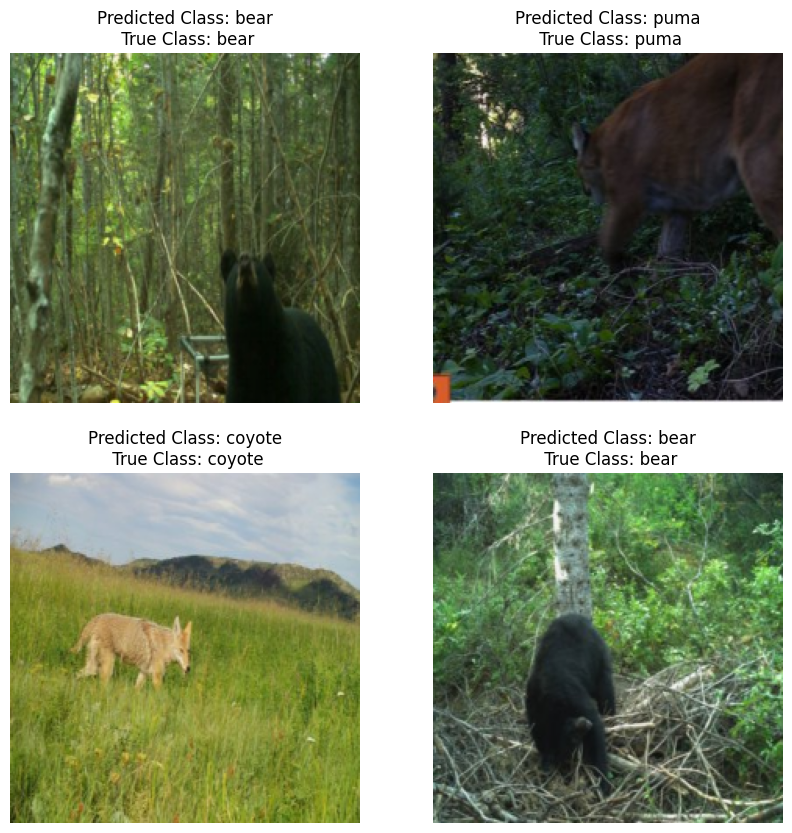

In [17]:
# Load and Visualize Model on Test Images

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This specific model is available in the Section 5 GitHub link
model_name = 'Day_model_ft_2025-03-31_03-39-55.pth'

model_path = (
    f'/content/TrainedModels/'
    f'{model_name}'
    )

# If you would like to read in a specific model, change 'save_path' to 'model_path'
# This is assuming you have specified a specific model above that is in your
# Google Drive 'My Drive'
model_ft.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model_ft.eval()


# Original labels based on dataset build folders
class_labels = test_data.classes
print("Raw Test Labels:", class_labels)

# Reset labels
print("Reset Test Labels:", new_labels)

# Plot some images and predictions (original 'class_names=test_data.classes')
visualize_model(model_ft, dataloader={'test': test_loader}, class_names=new_labels)

# Class numbers in order from 0 to 4
# 0 - deer, 1 - puma, 2 - elk, 3 - coyote, 4 - bear

---
---
## **16. Confusion matrix comparison**
##### A method for evaluating/visualizing the trained model's ability to correctly classify unseen images is by applying a confusion matrix.
* The resulting matrix can be plotted as a heat map to show when a class is correctly identified or when it is misidentified as another class
  * The entire test image set is evaluated instead of a small batch at a time
* First you must consider how many test images each class has
  * For this tutorial there are 13 images per class
* Next, since this tutorial has 5 classes, your confusion matrix will be a 5 x 5 matrix/array
* Next you have true labels on the y-axis of the heat map image
  * Note you can also simply consult the square matrix (printed above the heat map image) if desired
* The x-axis of the heat map image is the predicted labels
* Now consulting the generated heat map image, a perferct model would have 13(s)
down the diagonal of the image or matrix
  * This would mean that the true labels exactly match the predicted labels since we have 13 test images per class for this particular tutorial
  * Since the trained models are not perfect for this tutorial, the deer class often sees misclassifcations where a deer is confused with an elk
    * So lets say that 12 images were correctly identified as deer and 1 was confused with an elk- this would show 12, 0, 1, 0, 0 for the top row
  * The class that is often perfectly classified is bear, so the diagonal shows 13 for the bear true label vs predicted label
    * The last row for this instance shows 0, 0, 0, 0, 13 since all the instances match true vs predicted labels
* Overall, the confusion matrix heat map image is a quick way to see how your model handles unseen data and what instances are incorrectly classified and what classes get confused with each other
---

[[12  0  1  0  0]
 [ 0 12  0  1  0]
 [ 0  0 10  3  0]
 [ 2  0  0 11  0]
 [ 0  0  0  0 13]]


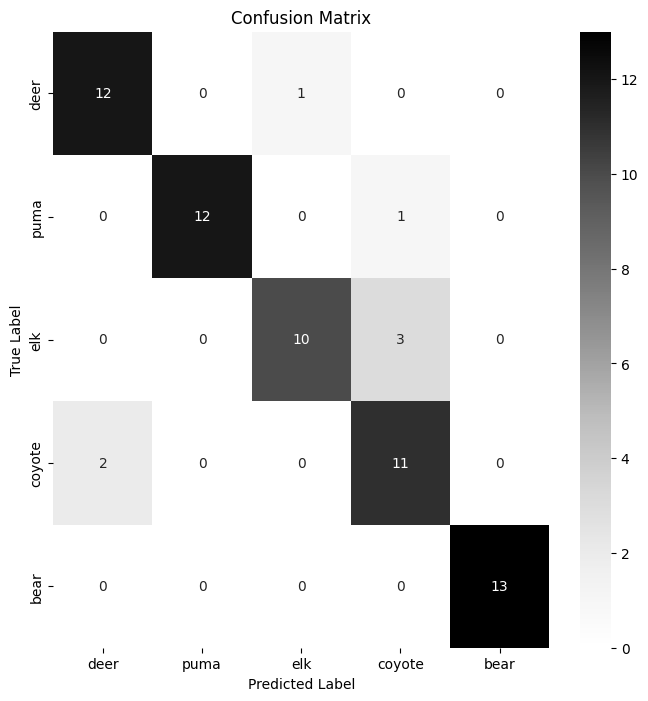

In [18]:
# Set model to evaluation mode so predictions can be made and stored

model_ft.eval()

all_preds = []
all_labels = []

# Load in some test images to generate predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get predictions and the actual labels for each
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Generate confusion matrix
conf_mx = confusion_matrix(all_labels, all_preds)
print(conf_mx)

# Plot the confusion matrix (original 'xticklabels=test_data.classes' and 'yticklabels=test_data.classes')
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mx, annot=True, fmt='d', cmap='Grays', xticklabels=new_labels, yticklabels=new_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Class numbers in order from 0 to 4
# 0 - deer, 1 - puma, 2 - elk, 3 - coyote, 4 - bear

In [19]:
# This last code cell is used to time the entire tutorials completion time
# consult the printed output of the cell to see the total time

# Get the time once this cell is processed
endT_all = np.datetime64('now')

# Display total time
# if this cell is reprocessed individually from 'Runtime -> Run all' it can give
# an inaccurate total time since it will grab a new current time

timeMinutes = ((endT_all - startT_all).astype('m8[s]').item().total_seconds())/60

print(f"Time elapsed for all cells (seconds): {endT_all - startT_all}")
print(f"Time in minutes: {timeMinutes:.2f}")

# GPU example: 7 minutes
# CPU example: 107.85 minutes

Time elapsed for all cells (seconds): 350 seconds
Time in minutes: 5.83


---
---
## **Extra Help Links**
##### Here are some extra resources to consider for this tutorial.
* Python help:
  * Effective Python: 125 Specific Ways to Write Better Python, 3rd Edition
by Brett Slatkin
    * O'Reilly access: [Effective Python: 125 Specific Ways to Write Better Python, 3rd Edition](https://www.oreilly.com/library/view/effective-python-125/9780138172398/)
    * Generic book website: [Effective Python](https://effectivepython.com/)
* PyTorch help:
  * [General Tutorials](https://pytorch.org/tutorials/)
  * [Image Transformations](https://pytorch.org/vision/stable/transforms.html)
  * [Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
* Scikit-Learn Examples:
  * [General Examples](https://scikit-learn.org/stable/auto_examples/index.html)
* Ultralytics YOLO Docs for future work:
  * [Ultralytics YOLO tutorials](https://docs.ultralytics.com/)
---